<a href="https://colab.research.google.com/github/ShepherdCode/ShepherdML/blob/master/Nasa2021/CNN_518.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 518

TWO CNNs with Max Pooling:

1.   Higher filters then neurons increased learning
2.   Drop out rate reduced overfitting in some tests, but not all.
3.   Model maxes out between 72-73% when not overfitting 
4.   Results are not consistent 












In [1]:
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'
NC_FILENAME='ncRNA.gc36.balance.fasta'
PC_FILENAME='pcRNA.gc36.balance.fasta'

MODEL_FILE='CNN518' 
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=10
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=2
FILTERS=16
KERNEL=3
NEURONS=8
DROP=0.5
MINLEN=200
MAXLEN=2000
DENSE_LEN = 1000
ACT="tanh"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [4]:
def compile_model(model):
    ## learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    SHAPE=(MAXLEN,5)  # 2000 time steps, 5 features
    clayer1 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same",
                                 input_shape=SHAPE)
    clayer2 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer3 = keras.layers.MaxPooling1D(2)
    #clayer4 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    #clayer5 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    #clayer6 = keras.layers.MaxPooling1D(2)
    clayer7 = keras.layers.Flatten()

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt, input_shape=[DENSE_LEN])
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    cnn = keras.models.Sequential()
    cnn.add(clayer1)
    cnn.add(clayer2)
    cnn.add(clayer3)
    #cnn.add(clayer4)
    #cnn.add(clayer5)
    #cnn.add(clayer6)
    cnn.add(clayer7)
    cnn.add(dlayer1)
    cnn.add(dlayer2)
    cnn.add(dlayer3)
    cnn.add(dlayer4)
    cnn.add(output_layer)
    mlpc = compile_model(cnn)
    return mlpc

Cross validation

In [5]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [6]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2000, 16)          256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1000, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 16000)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 128008    
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_____________________________________________________________

In [7]:
#MINLEN=200
#MAXLEN=2000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
subset=tools.make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
(X1,y_train)=tools.separate_X_and_y(subset)
# X1 is pandas df of ("list" of one sequence)
X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
X3=[elem[0] for elem in X2]  # numpy dnarray of str
X4=tools.uniform_length(X3,MAXLEN)
X5= [tools.one_hot(x) for x in X4]
X_train=np.asarray(X5)
y_train=y_train.to_numpy()

subset=None
X1=None
X2=None
X3=None
X4=None
X5=None

Load data from files.
Ready: train_set


Cross validation
COMPILE...
...COMPILED
FIT
Epoch 1/10
1000/1000 [==============================] - 7s 5ms/step - loss: 0.7421 - accuracy: 0.5082 - val_loss: 0.6879 - val_accuracy: 0.5666
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.1.best/assets
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6746 - accuracy: 0.5729 - val_loss: 0.5796 - val_accuracy: 0.7124
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.1.best/assets
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6035 - accuracy: 0.7025 - val_loss: 0.5740 - val_accuracy: 0.7157
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.1.best/assets
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5947 - accuracy: 0.7095 - val_loss: 0.5667 - val_accuracy: 0.7216
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.1.best/assets
Epoch 5/10
1000/1000 [======

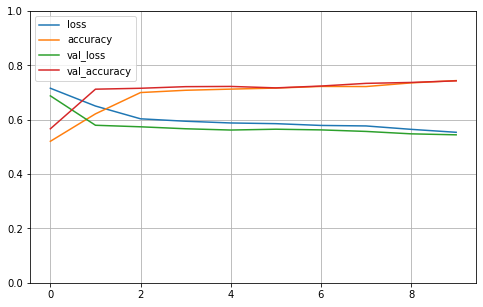

accuracy: 74.30%
COMPILE...
...COMPILED
FIT
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7211 - accuracy: 0.5315 - val_loss: 0.5908 - val_accuracy: 0.7059
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.2.best/assets
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6151 - accuracy: 0.6838 - val_loss: 0.5657 - val_accuracy: 0.7304
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.2.best/assets
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5958 - accuracy: 0.7049 - val_loss: 0.5610 - val_accuracy: 0.7281
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5820 - accuracy: 0.7191 - val_loss: 0.5693 - val_accuracy: 0.7214
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5804 - accuracy: 0.7200 - val_loss: 0.5583 - val_accuracy: 0.7304
Epoch 6/10
1000/1000 [==============================] - 5s 5

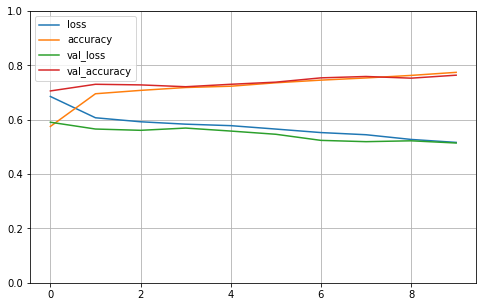

accuracy: 76.39%
COMPILE...
...COMPILED
FIT
Epoch 1/10
1000/1000 [==============================] - 6s 5ms/step - loss: 0.7520 - accuracy: 0.5155 - val_loss: 0.5997 - val_accuracy: 0.7205
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.3.best/assets
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6243 - accuracy: 0.6717 - val_loss: 0.5571 - val_accuracy: 0.7290
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.3.best/assets
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5953 - accuracy: 0.7054 - val_loss: 0.5538 - val_accuracy: 0.7366
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.3.best/assets
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5838 - accuracy: 0.7199 - val_loss: 0.5504 - val_accuracy: 0.7309
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5677 - accuracy: 0.7339 - val_loss: 0.

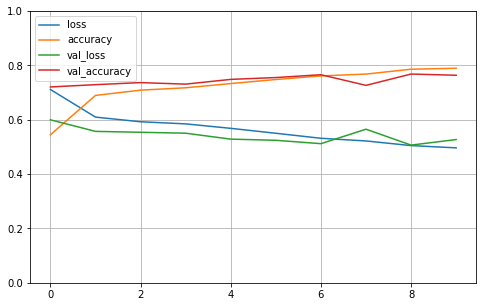

accuracy: 76.81%
COMPILE...
...COMPILED
FIT
Epoch 1/10
1000/1000 [==============================] - 6s 5ms/step - loss: 0.7036 - accuracy: 0.6158 - val_loss: 0.5590 - val_accuracy: 0.7261
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.4.best/assets
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5868 - accuracy: 0.7119 - val_loss: 0.5630 - val_accuracy: 0.7180
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5540 - accuracy: 0.7472 - val_loss: 0.5593 - val_accuracy: 0.7307
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.4.best/assets
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5252 - accuracy: 0.7658 - val_loss: 0.5128 - val_accuracy: 0.7630
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.4.best/assets
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5075 - accuracy: 0.7794 - val_loss: 0.

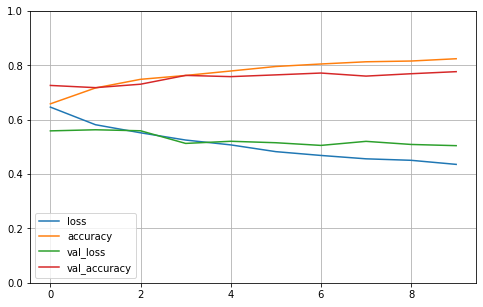

accuracy: 77.68%
COMPILE...
...COMPILED
FIT
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7835 - accuracy: 0.5432 - val_loss: 0.5764 - val_accuracy: 0.7169
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.5.best/assets
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6164 - accuracy: 0.6804 - val_loss: 0.5612 - val_accuracy: 0.7278
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.5.best/assets
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5804 - accuracy: 0.7168 - val_loss: 0.5514 - val_accuracy: 0.7391
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.5.best/assets
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5786 - accuracy: 0.7216 - val_loss: 0.5423 - val_accuracy: 0.7442
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/CNN518.cv.5.best/assets
Epoch 5/10
1000/1000 [======

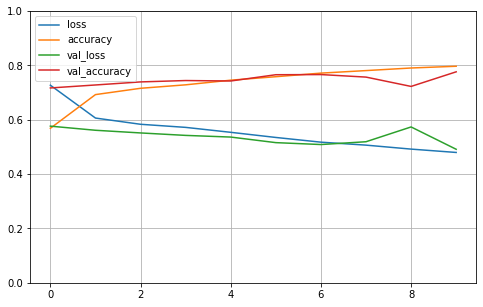

accuracy: 77.62%

5-way Cross Validation mean 76.56% (+/- 1.23%)
Done


In [8]:
print ("Cross validation")
do_cross_validation(X_train,y_train,model)  
print ("Done")